In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import warnings
import scipy.spatial
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
plt.style.use('csdh.mplstyle')

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

## Plotting Code

In [3]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [4]:
DATA_FILENAME = "xai_data.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME

In [5]:
csdh = pd.read_csv(DATA_FILEPATH).iloc[:,1:] # drop first index column

In [6]:
# convert burrhole_num from object to int64
csdh['burrhole_num'] = pd.to_numeric(csdh['burrhole_num'], errors='coerce')

In [7]:
csdh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 763 non-null    int64  
 1   sex                 763 non-null    int64  
 2   hospital            763 non-null    int64  
 3   diabetes            763 non-null    int64  
 4   dementia            763 non-null    int64  
 5   copd                763 non-null    int64  
 6   stroke              763 non-null    int64  
 7   ihd                 763 non-null    int64  
 8   arrhythmia          763 non-null    int64  
 9   epilepsy            763 non-null    int64  
 10  shunt               763 non-null    int64  
 11  malignancy          763 non-null    int64  
 12  metalvalve          763 non-null    int64  
 13  headinjury          763 non-null    int64  
 14  residence           763 non-null    int64  
 15  mobility            763 non-null    int64  
 16  adm_mrs 

In [8]:
# Summary stats
csdh.describe()

,age,sex,hospital,diabetes,dementia,copd,stroke,ihd,arrhythmia,epilepsy,shunt,malignancy,metalvalve,headinjury,residence,mobility,adm_mrs,adm_cogimpair,adm_seizure,adm_incontinence,adm_gait,adm_dysphasia,adm_hemiparesis,adm_headache,adm_facialdroop,gcs_e,gcs_v,gcs_m,gcs_preop,platelet,inr,antithrombotics,warfarin,antiplatelet,laterality,thickness_r,thickness_l,thickness_cleaned,midlineshift,density,membranes,steroid,optype,burrhole_num,surgeon,anaesthetic,csdhcolour,drain,drain_end,drain_entry,drain_days,timetoop_corrected,recurrence
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,495.000000,763.000000,763.000000,763.000000,763.0,763.000000,611.000000,763.000000,763.000000,762.000000,763.000000,637.000000,535.000000,637.000000,762.000000,745.000000
mean,74.255570,0.677588,11.218873,0.161206,0.110092,0.055046,0.163827,0.247706,0.207077,0.041940,0.009174,0.081258,0.019659,0.629096,1.304063,1.411533,2.939712,0.588467,0.038008,0.049803,0.323722,0.146789,0.418087,0.410223,0.035387,3.702490,4.110092,5.829620,13.642202,248.703801,1.115465,0.432503,0.190039,0.245085,1.908257,12.574050,13.061599,20.600000,8.155963,2.218873,0.394495,0.0,1.125819,1.918167,2.812582,1.072084,2.069554,0.834862,1.084772,1.652336,1.784929,3.811024,0.092617
std,14.017104,0.467706,7.960075,0.367962,0.313209,0.228219,0.370361,0.431964,0.405477,0.200583,0.095405,0.273410,0.138917,0.483364,0.651525,0.737786,1.298711,0.492434,0.191341,0.217681,0.468202,0.354128,0.493568,0.492197,0.184876,0.684919,1.028946,0.556341,1.993862,91.230010,0.361822,0.495748,0.392589,0.430420,0.814548,11.773818,11.056767,7.439472,5.716215,0.869766,0.489063,0.0,0.383247,0.400631,0.458514,0.258796,1.380031,0.371548,0.278762,0.476674,0.525356,9.505430,0.290090
min,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,40.000000,0.800000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,67.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,6.000000,14.000000,187.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.000000,5.000000,1.000000,0.000000,0.0,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,77.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,6.000000,14.000000,237.000000,1.000000,0.000000,0.000000,0.000000,2.000000,13.000000,14.000000,21.000000,8.000000,3.000000,0.000000,0.0,1.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000
75%,84.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,4.000000,5.000000,6.000000,15.000000,296.000000,1.100000,1.000000,0.000000,0.000000,3.000000,22.000000,22.000000,26.000000,11.000000,3.000000,1.000000,0.0,1.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.

In [9]:
csdh.tail()

,age,sex,hospital,diabetes,dementia,copd,stroke,ihd,arrhythmia,epilepsy,shunt,malignancy,metalvalve,headinjury,residence,mobility,adm_mrs,adm_cogimpair,adm_seizure,adm_incontinence,adm_gait,adm_dysphasia,adm_hemiparesis,adm_headache,adm_facialdroop,gcs_e,gcs_v,gcs_m,gcs_preop,platelet,inr,antithrombotics,warfarin,antiplatelet,laterality,thickness_r,thickness_l,thickness_cleaned,midlineshift,density,membranes,steroid,optype,burrhole_num,surgeon,anaesthetic,csdhcolour,drain,drain_end,drain_entry,drain_days,timetoop_corrected,bedrest,recurrence
758,96,0,18,0,0,0,0,0,0,0,0,0,0,1,3,2,2,1,0,0,0,0,1,0,0,4,4,6,14,188,1.2,0,0,0,2,26,0,NaN,7,1,0,0,1,2.0,2,1,1.0,1,2.0,2.0,2.0,1.0,12-24hrs,0.0
759,96,0,3,0,1,0,0,0,0,0,0,0,0,0,2,3,5,1,0,1,0,1,1,0,0,4,4,6,14,206,1.0,0,0,0,1,0,18,18.0,0,1,0,0,1,1.0,2,2,3.0,1,1.0,NaN,1.0,5.0,<12hrs,0.0
760,97,1,4,0,0,0,0,0,0,0,0,0,0,0,3,3,4,0,0,0,0,1,1,0,0,4,4,6,14,309,1.0,1,0,1,3,14,28,28.0,7,3,1,0,1,2.0,3,2,1.0,1,1.0,NaN,1.0,1.0,12-24hrs,0.0
761,98,1,18,0,0,0,0,0,0,0,0,0,0,1,2,2,3,1,0,0,0,0,0,0,0,4,4,6,14,267,0.9,0,0,0,1,0,30,30.0,10,2,1,0,1,2.0,2,1,1.0,1,1.0,2.0,2.0,3.0,12-24hrs,0.0
762,99,1,6,0,0,0,0,0,0,0,0,0,0,0,2,2,4,1,0,0,0,0,1,0,0,4,4,6,14,313,1.0,0,0,0,2,29,0,NaN,18,2,0,0,1,2.0,3,1,1.0,1,1.0,1.0,2.0,2.0,None,0.0


In [10]:
# Fix bilateral data entries
csdh.at[68, 'laterality'] = 3
csdh.at[284, 'laterality'] = 3
csdh.at[313, 'laterality'] = 3
csdh.at[387, 'laterality'] = 3
csdh.at[502, 'laterality'] = 3
csdh.at[508, 'laterality'] = 3

# Fix unilateral left-->right
csdh.at[81, 'laterality'] = 2
csdh.at[105, 'laterality'] = 2
csdh.at[205, 'laterality'] = 2
csdh.at[472, 'laterality'] = 2
csdh.at[545, 'laterality'] = 2
csdh.at[553, 'laterality'] = 2
csdh.at[634, 'laterality'] = 2
csdh.at[733, 'laterality'] = 2
csdh.at[752, 'laterality'] = 2

# Fix unilateral right-->left
csdh.at[81, 'laterality'] = 1
csdh.at[105, 'laterality'] = 1
csdh.at[351, 'laterality'] = 1
csdh.at[438, 'laterality'] = 1

In [11]:
csdh['thickness_sum'] = csdh['thickness_l'] + csdh['thickness_r']

In [12]:
mask_bi = (csdh['laterality'] == 3)
mask_l = (csdh['laterality'] == 1)
mask_r = (csdh['laterality'] == 2)
csdh_bi = csdh[mask_bi]
csdh_l = csdh[mask_l]
csdh_r = csdh[mask_r]
csdh['thickness_avg'] = 0
csdh.loc[mask_bi, 'thickness_avg'] = (csdh_bi['thickness_l'] + csdh_bi['thickness_r']) / 2
csdh.loc[mask_l, 'thickness_avg'] = csdh_l['thickness_l']
csdh.loc[mask_r, 'thickness_avg'] = csdh_r['thickness_r']

In [13]:
csdh.at[81, 'thickness_avg'] = 13.0
csdh.at[105, 'thickness_avg'] = 21.0
csdh.at[217, 'thickness_avg'] = 25.0

In [14]:
csdh['thickness_max'] = csdh[['thickness_l', 'thickness_r']].max(axis=1)

In [15]:
csdh[['thickness_l', 'thickness_r', 'thickness_sum', 'thickness_avg', 'thickness_max']]

,thickness_l,thickness_r,thickness_sum,thickness_avg,thickness_max
0,0,20,20,20.0,20
1,6,0,6,6.0,6
2,9,13,22,11.0,13
3,8,0,8,8.0,8
4,10,0,10,10.0,10
5,30,0,30,30.0,30
6,10,0,10,10.0,10
7,19,6,25,12.5,19
8,0,8,8,8.0,8
9,16,0,16,16.0,16


In [16]:
# Make new bilateral binary variable
csdh['bilateral'] = 0
csdh.loc[mask_bi, 'bilateral'] = 1

In [17]:
csdh.keys()

Index(['age', 'sex', 'hospital', 'diabetes', 'dementia', 'copd', 'stroke',
       'ihd', 'arrhythmia', 'epilepsy', 'shunt', 'malignancy', 'metalvalve',
       'headinjury', 'residence', 'mobility', 'adm_mrs', 'adm_cogimpair',
       'adm_seizure', 'adm_incontinence', 'adm_gait', 'adm_dysphasia',
       'adm_hemiparesis', 'adm_headache', 'adm_facialdroop', 'gcs_e', 'gcs_v',
       'gcs_m', 'gcs_preop', 'platelet', 'inr', 'antithrombotics', 'warfarin',
       'antiplatelet', 'laterality', 'thickness_r', 'thickness_l',
       'thickness_cleaned', 'midlineshift', 'density', 'membranes', 'steroid',
       'optype', 'burrhole_num', 'surgeon', 'anaesthetic', 'csdhcolour',
       'drain', 'drain_end', 'drain_entry', 'drain_days', 'timetoop_corrected',
       'bedrest', 'recurrence', 'thickness_sum', 'thickness_avg',
       'thickness_max', 'bilateral'],
      dtype='object')

In [18]:
reduced_cols = ['age', 'sex', 'hospital', 'surgeon', 'drain', 'optype']

In [19]:
viz_df = csdh.copy()[reduced_cols]

In [20]:
viz_df.tail(10)

,age,sex,hospital,surgeon,drain,optype
753,94,0,11,3,1,1
754,94,0,24,3,1,1
755,95,1,5,3,1,1
756,95,1,4,3,1,1
757,95,0,19,3,1,1
758,96,0,18,2,1,1
759,96,0,3,2,1,1
760,97,1,4,3,1,1
761,98,1,18,2,1,1
762,99,1,6,3,1,1


---
# DataViz Begins...

## Distributional Summary

In [21]:
print(f"The median patient age is {viz_df.age.median()}")

The median patient age is 77.0


In [22]:
sum(csdh['drain'] == 1)

637

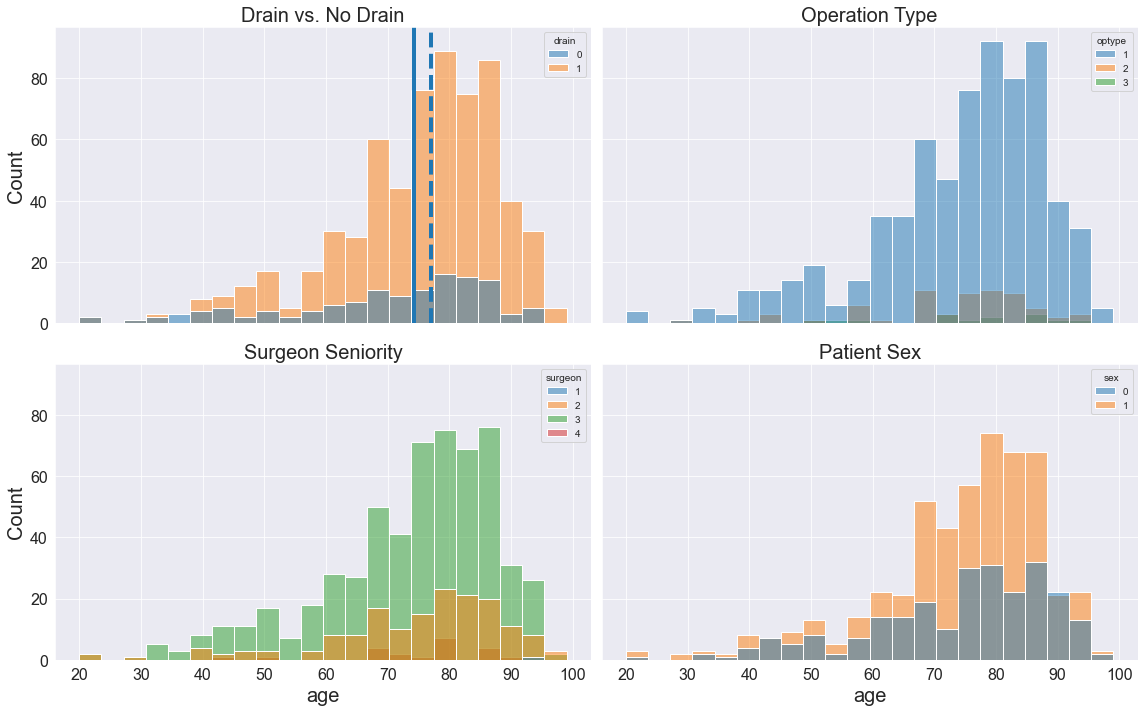

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

# ax1
sns.histplot(data = viz_df, x='age', hue='drain', ax=ax1, palette='tab10')
ax1.axvline(viz_df.age.mean(), lw=4, label='mean')
ax1.axvline(viz_df.age.median(), ls='--', lw=4, label='median')
ax1.set_title('Drain vs. No Drain')

# ax2
sns.histplot(data = viz_df, x='age', hue='optype', palette='tab10', ax=ax2)
ax2.set_title('Operation Type')

# ax3
sns.histplot(data = viz_df, x='age', hue='surgeon', palette='tab10', ax=ax3)
ax3.set_title('Surgeon Seniority')

# ax4
sns.histplot(data = viz_df, x='age', hue='sex', palette='tab10', ax=ax4)
ax4.set_title('Patient Sex')

plt.tight_layout()
plt.savefig('figs/summary_stats.png')
plt.show()

## Categorical Summary

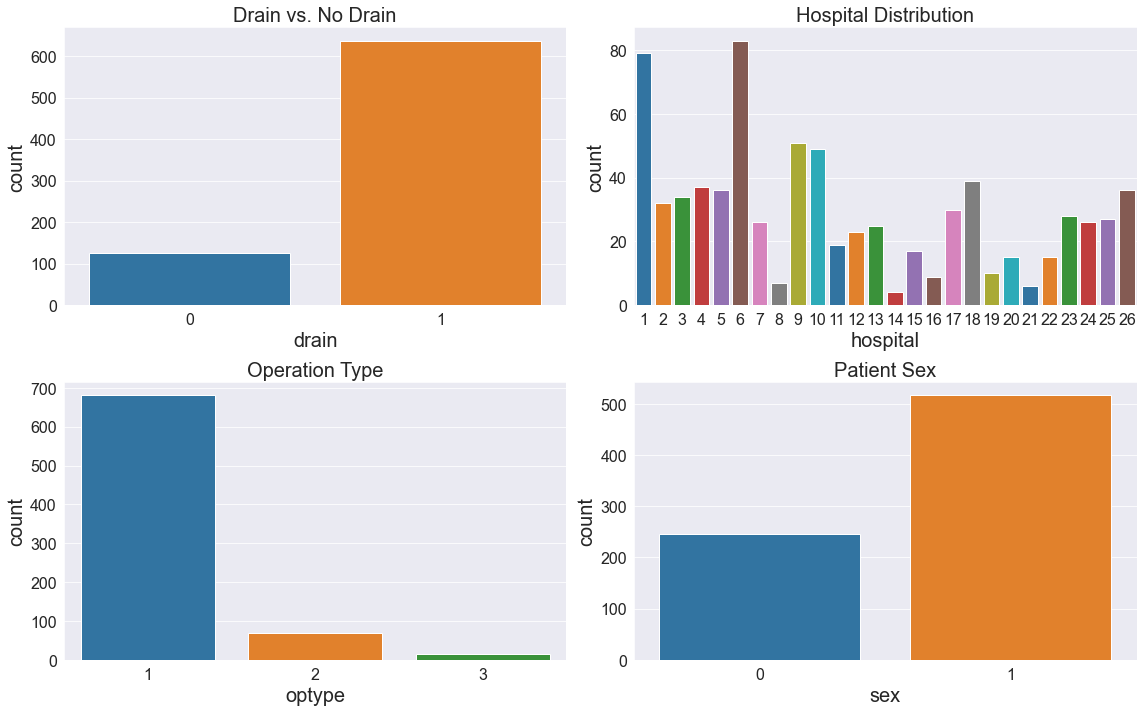

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# ax1
sns.countplot(data=viz_df, x='drain', palette='tab10', ax=ax1)
ax1.set_title('Drain vs. No Drain')

# ax2
sns.countplot(data=viz_df, x='hospital',palette='tab10', ax=ax2)
ax2.set_title('Hospital Distribution')

# ax3
sns.countplot(data=viz_df, x='optype', palette='tab10', ax=ax3)
ax3.set_title('Operation Type')

# ax4
sns.countplot(data = viz_df, x='sex', palette='tab10', ax=ax4)
ax4.set_title('Patient Sex')

plt.tight_layout()
plt.savefig('figs/categorical_summary.png')
plt.show()

# Missing Data

In [25]:
md_df = csdh.groupby('drain')
md_df = md_df.apply(lambda x: x.isna().sum())

In [26]:
md_df = md_df.loc[:, (md_df != 0).any(axis=0)].transpose()

In [27]:
md_df.loc[:,'total'] = md_df.sum(axis=1)

In [28]:
md_df = md_df.reset_index().rename(columns={'index':'covariate', 0:'no_drain', 1:'drained'})

In [29]:
md_df = md_df.sort_values(by='total', ascending=False)

In [30]:
md_df

drain,covariate,no_drain,drained,total
0,thickness_cleaned,41,227,268
4,drain_entry,126,102,228
1,burrhole_num,28,124,152
3,drain_end,126,0,126
5,drain_days,126,0,126
7,recurrence,3,15,18
2,csdhcolour,1,0,1
6,timetoop_corrected,0,1,1


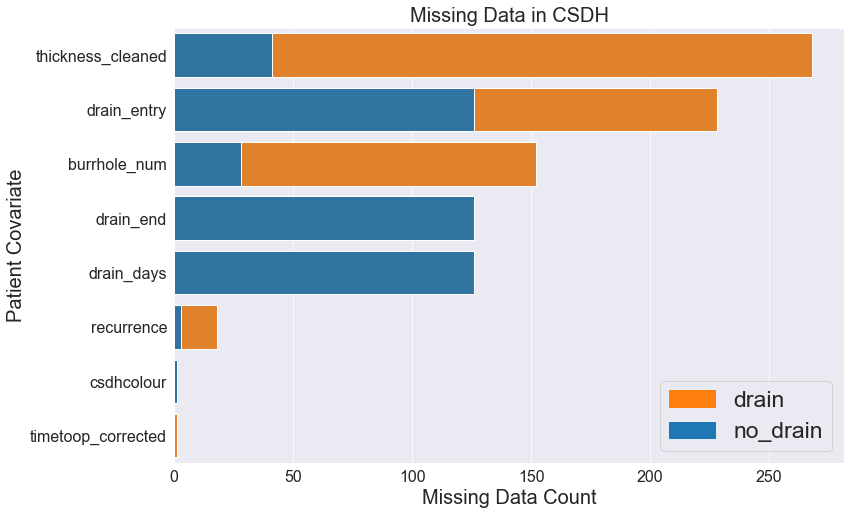

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
s1 = sns.barplot(y='covariate', x='total', data=md_df, color=sns.color_palette('tab10')[1])
s2 = sns.barplot(y='covariate', x='no_drain', data=md_df, color=sns.color_palette('tab10')[0])
ax.set(xlabel='Missing Data Count', ylabel='Patient Covariate', title='Missing Data in CSDH')
drain_patch = mpatches.Patch(color=sns.color_palette('tab10')[1], label='drain')
no_drain_patch = mpatches.Patch(color=sns.color_palette('tab10')[0], label='no_drain')

ax.legend(handles=[drain_patch, no_drain_patch], loc='lower right', fontsize=23)
plt.savefig('figs/missing_data')
plt.show()

In [32]:
csdh_burr = csdh[csdh['optype'] == 1.]

In [33]:
csdh_burr = csdh_burr.apply(lambda x: x.isna().sum())

In [34]:
csdh_burr['burrhole_num']

97

In [35]:
# drop patients with missing recurrence data
idxs = csdh[csdh['recurrence'].isna()].index
csdh.drop(idxs, inplace=True)

In [36]:
sum(csdh.recurrence.isna())

0

---

# DAG Variables

In [37]:
csdh.keys()

Index(['age', 'sex', 'hospital', 'diabetes', 'dementia', 'copd', 'stroke',
       'ihd', 'arrhythmia', 'epilepsy', 'shunt', 'malignancy', 'metalvalve',
       'headinjury', 'residence', 'mobility', 'adm_mrs', 'adm_cogimpair',
       'adm_seizure', 'adm_incontinence', 'adm_gait', 'adm_dysphasia',
       'adm_hemiparesis', 'adm_headache', 'adm_facialdroop', 'gcs_e', 'gcs_v',
       'gcs_m', 'gcs_preop', 'platelet', 'inr', 'antithrombotics', 'warfarin',
       'antiplatelet', 'laterality', 'thickness_r', 'thickness_l',
       'thickness_cleaned', 'midlineshift', 'density', 'membranes', 'steroid',
       'optype', 'burrhole_num', 'surgeon', 'anaesthetic', 'csdhcolour',
       'drain', 'drain_end', 'drain_entry', 'drain_days', 'timetoop_corrected',
       'bedrest', 'recurrence', 'thickness_sum', 'thickness_avg',
       'thickness_max', 'bilateral'],
      dtype='object')

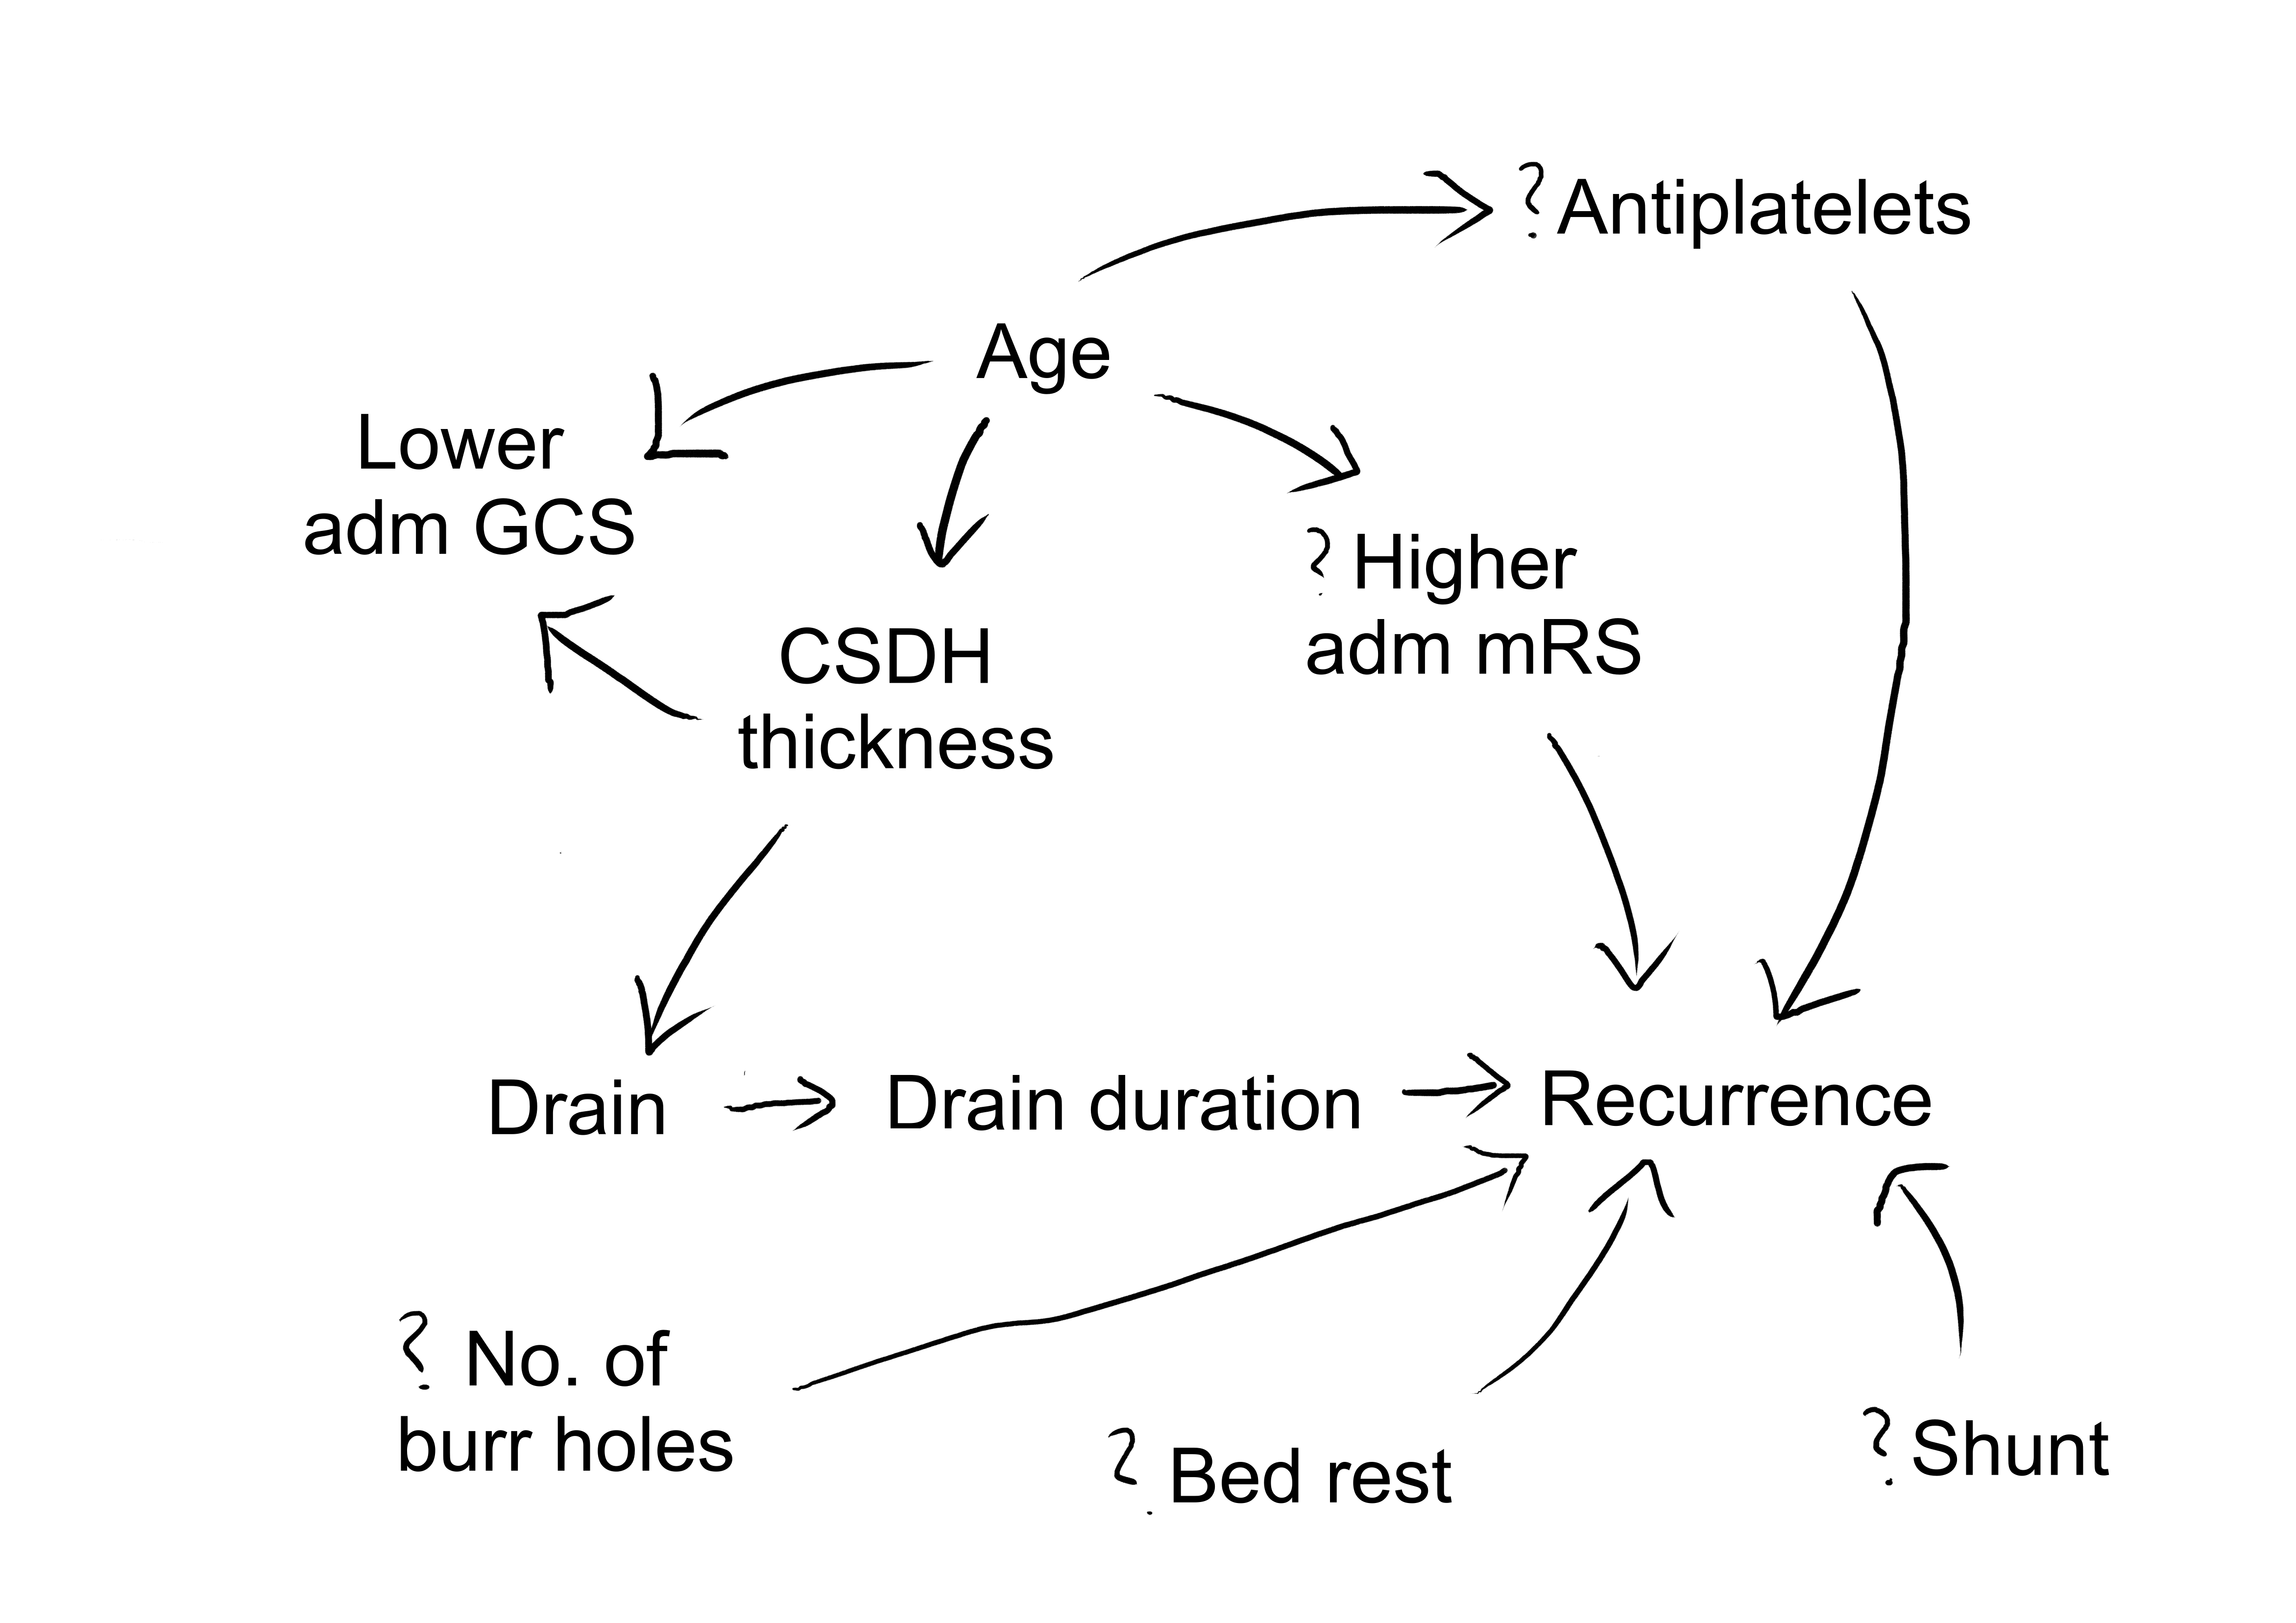

In [38]:
dag_vars = [
    'age', 'thickness_cleaned', 
    'gcs_preop', 'adm_mrs', 
    'antiplatelet', 'drain', 
    'drain_days', 'recurrence',
    'burrhole_num', 'shunt'
]

In [39]:
csdh_dag = csdh[dag_vars]
csdh_dag.head()

,age,thickness_cleaned,gcs_preop,adm_mrs,antiplatelet,drain,drain_days,recurrence,burrhole_num,shunt
0,20,NaN,15,1,0,0,NaN,1.0,1.0,1
1,23,6.0,14,2,0,1,2.0,0.0,2.0,0
2,23,13.0,15,2,0,1,2.0,0.0,2.0,0
3,23,8.0,15,0,0,0,NaN,0.0,2.0,0
4,28,10.0,15,3,0,0,NaN,0.0,2.0,0


In [40]:
sum(csdh_dag['recurrence'] == 1.0) / csdh_dag.shape[0] * 100
sum(csdh_dag['recurrence'] == pd.isnull(csdh_dag['recurrence']))

676

In [41]:
(csdh_dag['recurrence'] == 1.0).shape[0]

745

## Thickness

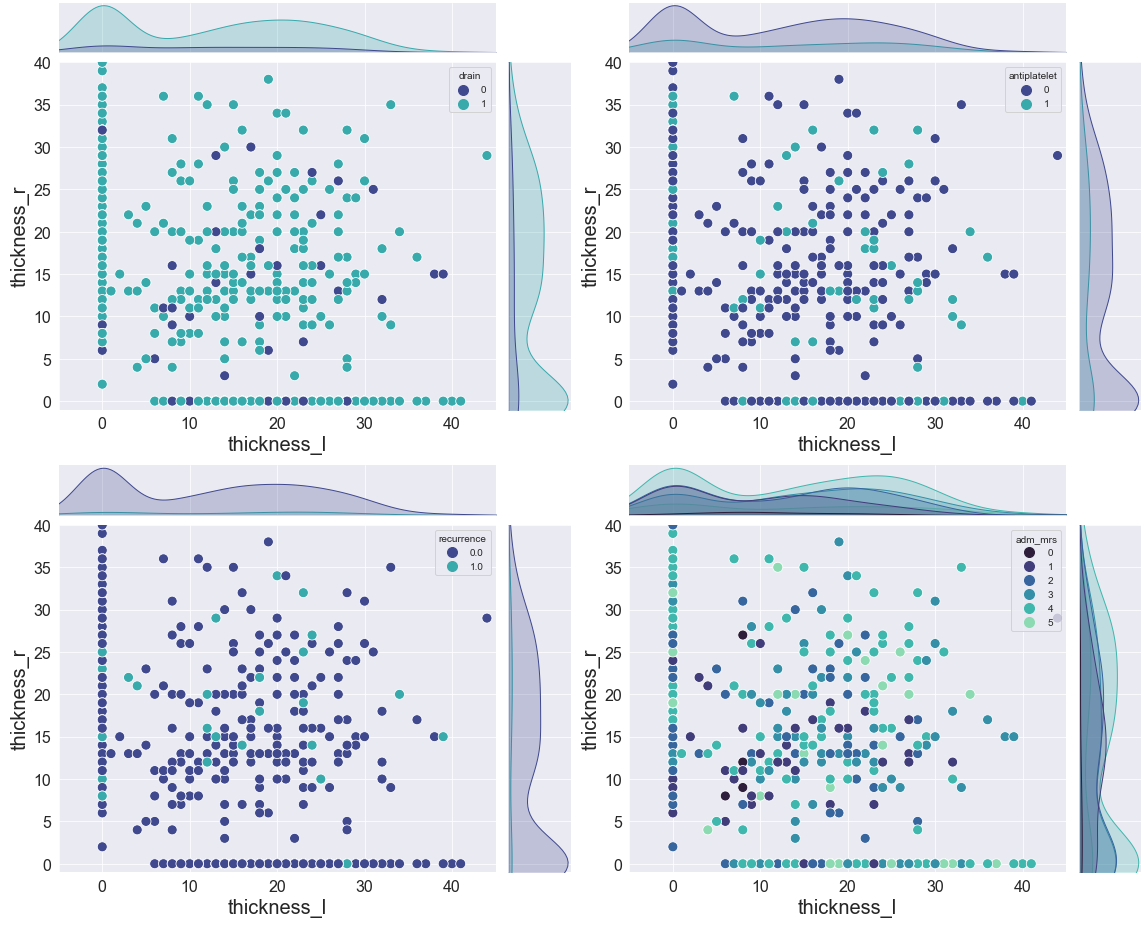

In [42]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns;

g0 = sns.jointplot(data=csdh, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="drain", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", 2))


g1 = sns.jointplot(data=csdh, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="antiplatelet", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", 2))

g2 =  sns.jointplot(data=csdh, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="recurrence", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", 2))

g3 =  sns.jointplot(data=csdh, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="adm_mrs", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", len(csdh['adm_mrs'].unique())))

# g3 = sns.lmplot(data=csdh_dag,
#                 x="age",
#                 y="thickness_cleaned",
#                 hue='drain',
#                 palette=sns.color_palette("mako", 2)
#                )

fig = plt.figure(figsize=(16,13))
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])
mg3 = SeabornFig2Grid(g3, fig, gs[3])

gs.tight_layout(fig)
plt.savefig('figs/thickness_w_0s')

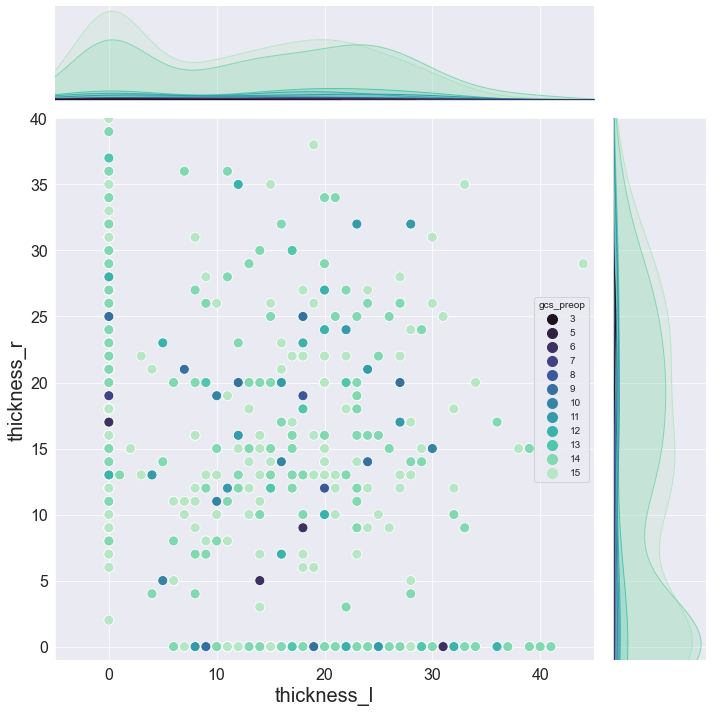

In [43]:
sns.jointplot(data=csdh, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="gcs_preop", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", 12))
plt.show()

### Let's have a look at those patients who have measurements for both `thickness_l` and `thickness_r` grouped by the `drain variable` (left and middle). No obvious pattern emerging

### What if we grouped by surgeon? Paul and Michael mentioned that senior surgeons often take over if there are complications? Maybe complications are more likely to arise if the hematoma is larger? Nope.

### We do observe, as Paul and Michael expected, patients with a larger hematoma presented a higher MRS score upon submission.

In [44]:
csdh_thick = csdh[(csdh['thickness_l'] != 0) & (csdh['thickness_r'] != 0)]


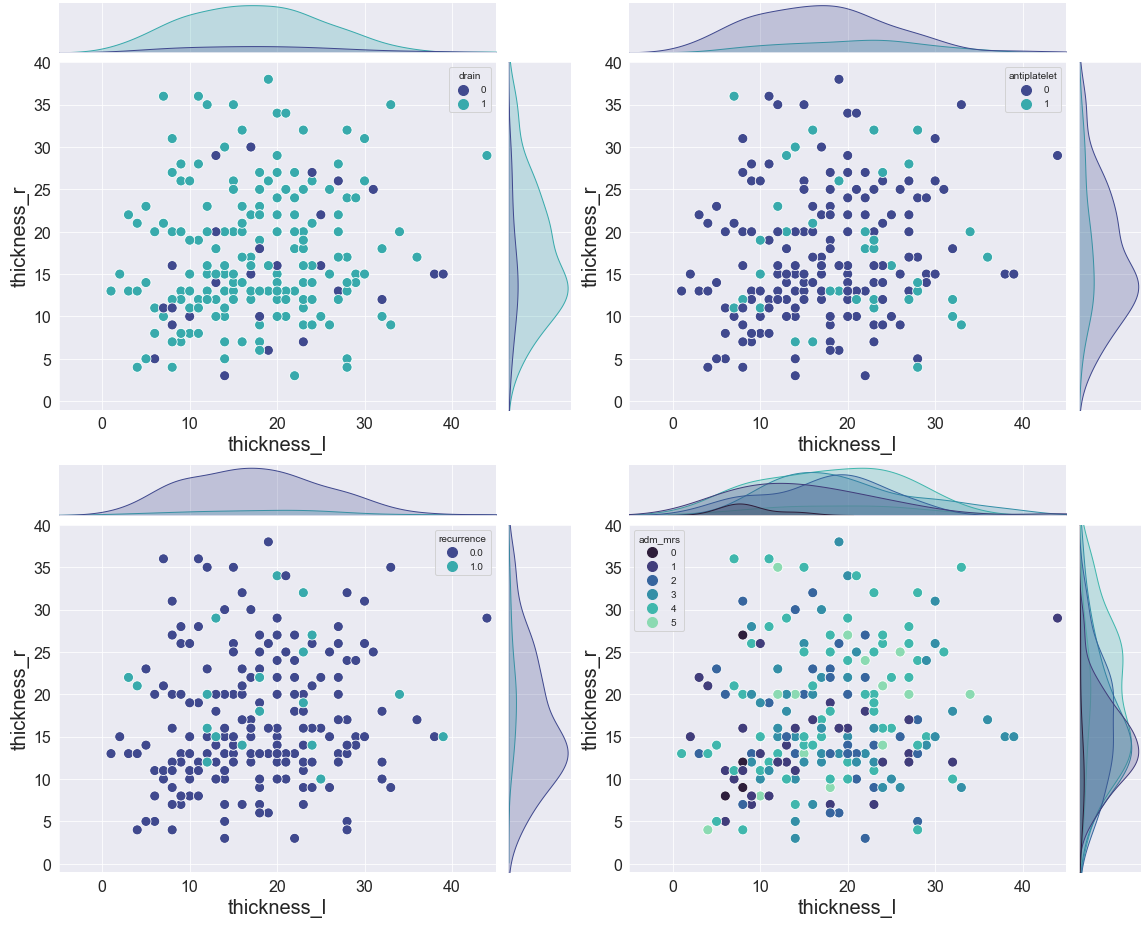

In [45]:
g0 = sns.jointplot(data=csdh_thick, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="drain", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", 2))

g1 = sns.jointplot(data=csdh_thick, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="antiplatelet", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", 2))

g2 =  sns.jointplot(data=csdh_thick, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="recurrence", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", 2))

g3 =  sns.jointplot(data=csdh_thick, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="adm_mrs", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", len(csdh['adm_mrs'].unique())))

# g3 = sns.lmplot(data=csdh_dag,
#                 x="age",
#                 y="thickness_cleaned",
#                 hue='drain',
#                 palette=sns.color_palette("mako", 2)
#                )

fig = plt.figure(figsize=(16,13))
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])
mg3 = SeabornFig2Grid(g3, fig, gs[3])

gs.tight_layout(fig)
plt.savefig('figs/thickness_no_0s')


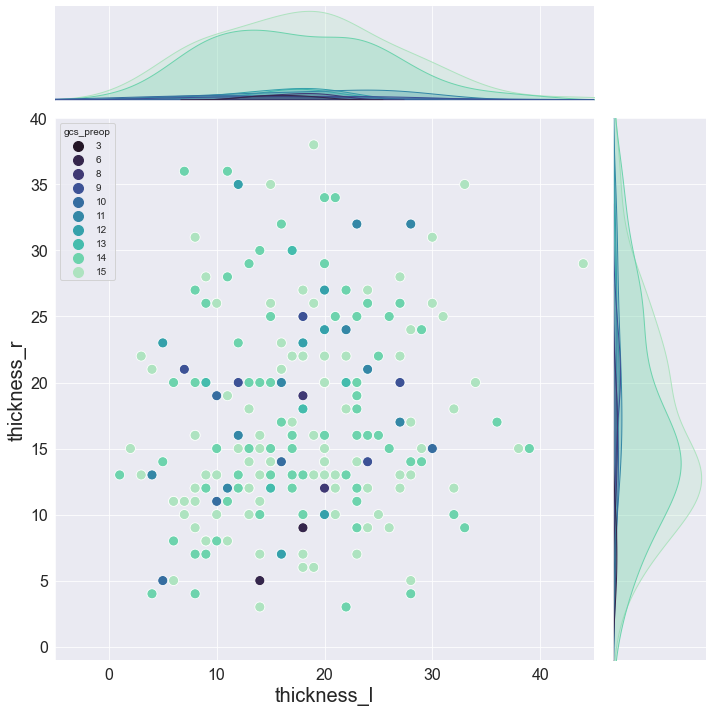

In [46]:
sns.jointplot(data=csdh_thick, 
                   x="thickness_l", 
                   y="thickness_r", 
                   hue="gcs_preop", 
                   xlim=(-5,45),
                   ylim=(-1, 40),
                   height=10, palette=sns.color_palette("mako", 10))
plt.show()

---


### Shunt is useless since the subset of people with both `recurrence==1` AND `shunt==1` is 0.

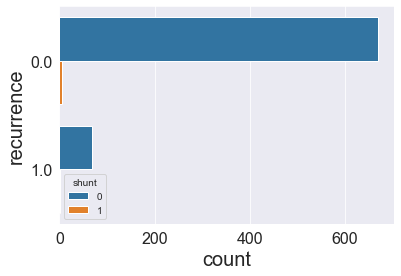

In [47]:
sns.countplot(y=csdh["recurrence"], hue=csdh['shunt'])
plt.savefig('figs/shunt.png')
plt.show()

## "Direct" Causes Investigation

In [48]:
platelet = csdh_dag.groupby(['antiplatelet', 'recurrence']).size().reset_index().pivot(columns='antiplatelet', index='recurrence', values=0)
platelet_prop = platelet.div(platelet.sum(axis=1), axis=0)

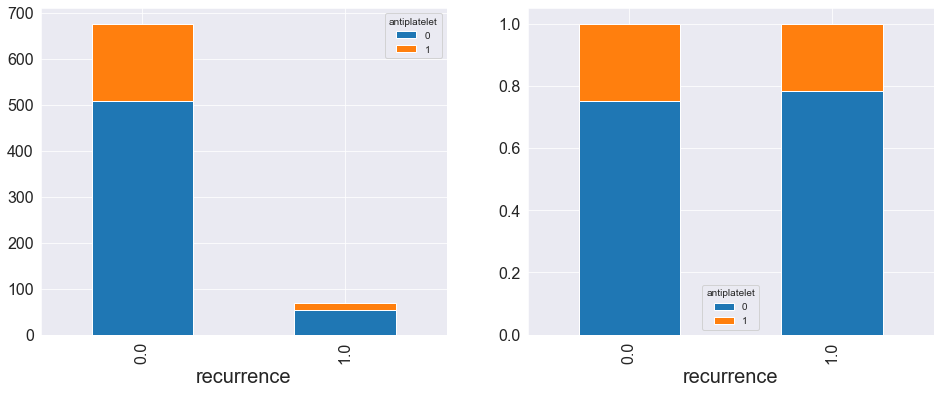

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
platelet.plot(kind='bar', stacked=True, ax=axs[0])
platelet_prop.plot(kind='bar', stacked=True, ax=axs[1])
plt.savefig('figs/rec_plate')
plt.show()

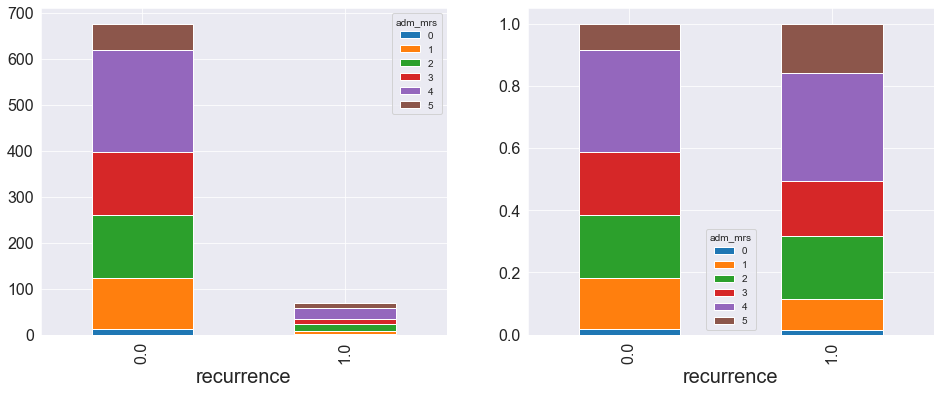

In [50]:
mrs = csdh_dag.groupby(['adm_mrs', 'recurrence']).size().reset_index().pivot(columns='adm_mrs', index='recurrence', values=0)
mrs_prop = mrs.div(mrs.sum(axis=1), axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
mrs.plot(kind='bar', stacked=True, ax=axs[0])
mrs_prop.plot(kind='bar', stacked=True, ax=axs[1])
plt.savefig('figs/rec_mrs')
plt.show()

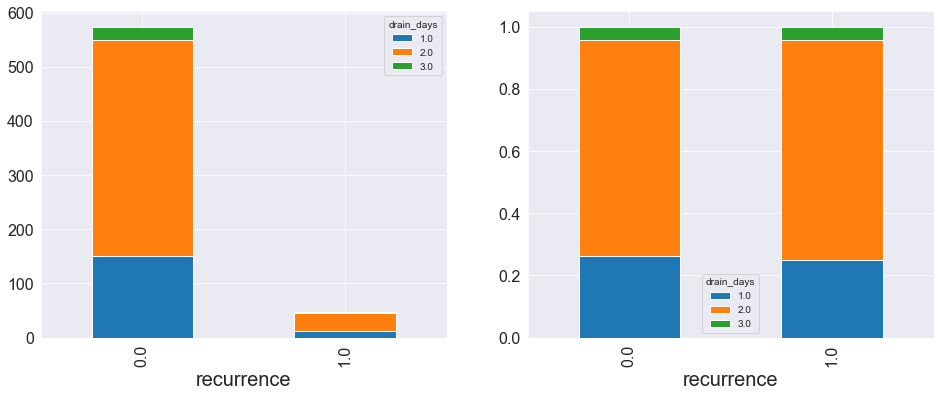

In [51]:
days = csdh_dag.groupby(['drain_days', 'recurrence']).size().reset_index().pivot(columns='drain_days', index='recurrence', values=0)
days_prop = days.div(days.sum(axis=1), axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
days.plot(kind='bar', stacked=True, ax=axs[0])
days_prop.plot(kind='bar', stacked=True, ax=axs[1])
plt.savefig('figs/rec_duration')

plt.show()

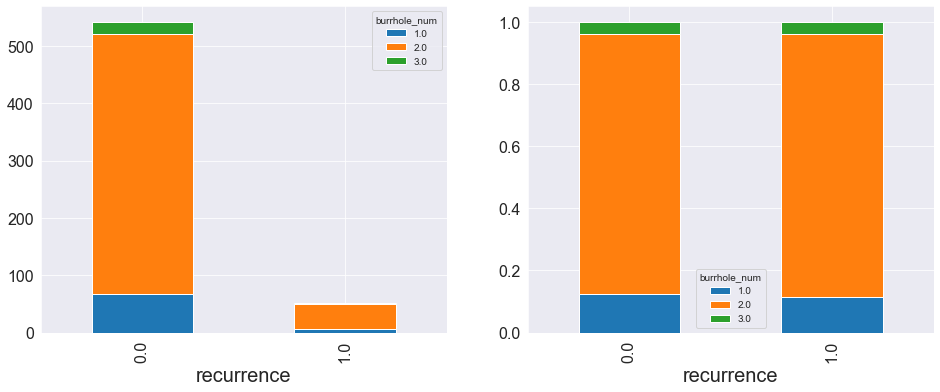

In [52]:
burr = csdh_dag.groupby(['burrhole_num', 'recurrence']).size().reset_index().pivot(columns='burrhole_num', index='recurrence', values=0)
burr_prop = burr.div(burr.sum(axis=1), axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
burr.plot(kind='bar', stacked=True, ax=axs[0])
burr_prop.plot(kind='bar', stacked=True, ax=axs[1])
plt.show()

## Promising relationship between `drain` and `recurrence`. A naïve analysis shows that the subset of people without a recurrence of CSDH had an approx. 20% increase in the population of patient who received the treatment `drain == 1`.

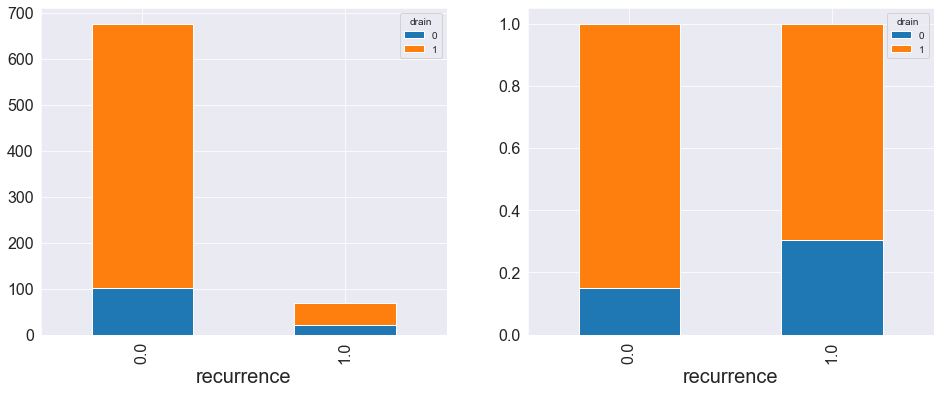

In [53]:
drain = csdh_dag.groupby(['drain', 'recurrence']).size().reset_index().pivot(columns='drain', index='recurrence', values=0)
drain_prop = drain.div(drain.sum(axis=1), axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
drain.plot(kind='bar', stacked=True, ax=axs[0])
drain_prop.plot(kind='bar', stacked=True, ax=axs[1])
plt.savefig('figs/rec_drain')

plt.show()

### I think `burrhole_num` should not be independent of `drain` and that it should slot somewhere along the direct path from `drain` to `recurrence`. There is clearly some relationship here...

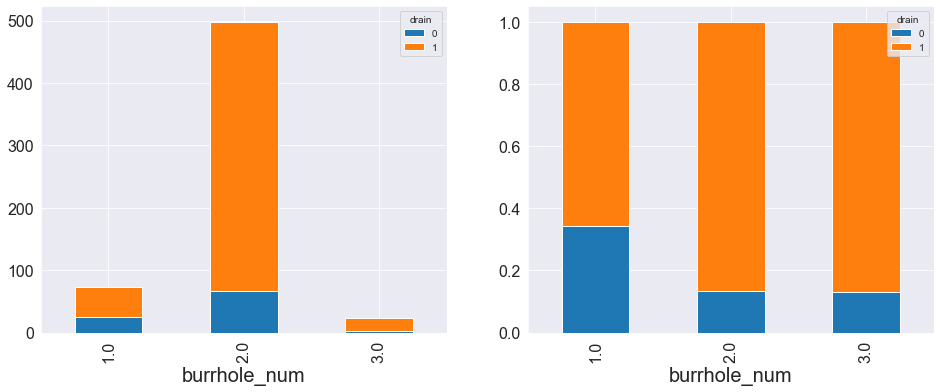

In [54]:
burr_drain = csdh_dag.groupby(['drain', 'burrhole_num']).size().reset_index().pivot(columns='drain', index='burrhole_num', values=0)
burr_drain_prop = burr_drain.div(burr_drain.sum(axis=1), axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
burr_drain.plot(kind='bar', stacked=True, ax=axs[0])
burr_drain_prop.plot(kind='bar', stacked=True, ax=axs[1])
plt.savefig('figs/rec_burr')
plt.show()

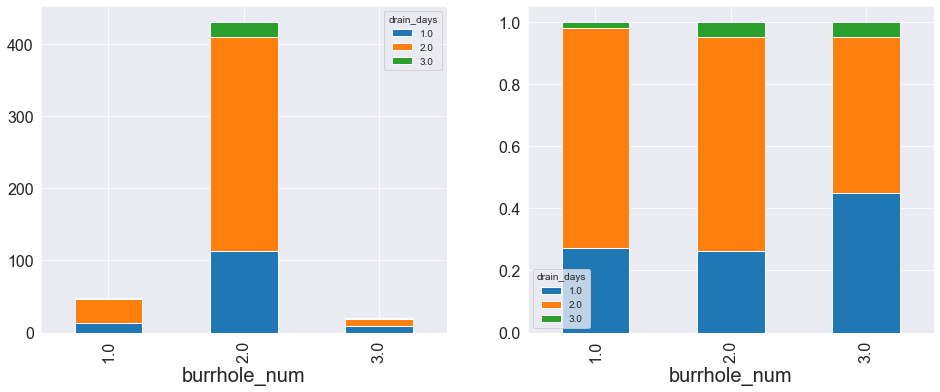

In [55]:
days = csdh_dag.groupby(['drain_days', 'burrhole_num']).size().reset_index().pivot(columns='drain_days', index='burrhole_num', values=0)
days_prop = days.div(days.sum(axis=1), axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
days.plot(kind='bar', stacked=True, ax=axs[0])
days_prop.plot(kind='bar', stacked=True, ax=axs[1])
plt.savefig('figs/days_burr')

plt.show()

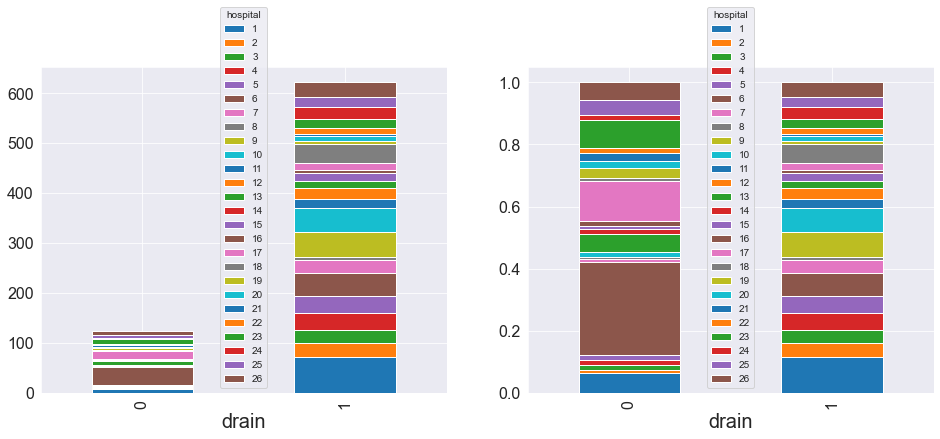

In [67]:
iv = csdh.groupby(['hospital', 'drain']).size().reset_index().pivot(columns='hospital', index='drain', values=0)
iv_prop = iv.div(iv.sum(axis=1), axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
iv.plot(kind='bar', stacked=True, ax=axs[0])
iv_prop.plot(kind='bar', stacked=True, ax=axs[1])
plt.savefig('figs/surgeon_drain')

plt.show()

# Model 01

In [56]:
# Grab relevant features from dataset
csdh_01 = csdh[['age', 'antiplatelet', 'thickness_sum', 'gcs_preop', 'adm_mrs', 'drain', 'recurrence']]

In [57]:
corr = csdh.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,sex,hospital,diabetes,dementia,copd,stroke,ihd,arrhythmia,epilepsy,shunt,malignancy,metalvalve,headinjury,residence,mobility,adm_mrs,adm_cogimpair,adm_seizure,adm_incontinence,adm_gait,adm_dysphasia,adm_hemiparesis,adm_headache,adm_facialdroop,gcs_e,gcs_v,gcs_m,gcs_preop,platelet,inr,antithrombotics,warfarin,antiplatelet,laterality,thickness_r,thickness_l,thickness_cleaned,midlineshift,density,membranes,steroid,optype,burrhole_num,surgeon,anaesthetic,csdhcolour,drain,drain_end,drain_entry,drain_days,timetoop_corrected,recurrence,thickness_sum,thickness_avg,thickness_max,bilateral
age,1.000000,0.011925,-0.029092,0.081655,0.194250,0.107741,0.159173,0.206725,0.178884,-0.121828,-0.119604,0.042260,0.077360,0.132005,0.265006,0.252351,0.304957,0.252826,-0.083125,0.054361,0.157663,0.073586,0.187654,-0.318027,0.009426,-0.023451,-0.179468,-0.028637,-0.108689,-0.082659,0.085030,0.224363,0.118727,0.150962,0.074301,0.128615,0.075422,0.187088,-0.099695,0.081772,0.154127,nan,-0.019829,0.030542,-0.019781,0.155821,0.012325,0.145738,-0.014057,0.101652,0.040095,0.025353,0.008276,0.219103,0.200919,0.217086,0.059603
sex,0.011925,1.000000,-0.032789,0.047783,-0.065994,0.094379,-0.024814,0.074044,0.036340,-0.028331,-0.021877,0.035949,-0.023444,-0.007624,-0.066080,-0.066190,-0.077732,-0.055888,0.031044,-0.066444,0.085176,0.007312,-0.000414,0.052420,0.006422,0.045539,0.084798,0.025208,0.066392,-0.155311,0.042456,0.058869,0.070408,0.021321,0.024404,0.056277,0.042490,0.089756,0.056155,-0.057320,0.067057,nan,-0.011989,-0.015141,-0.031430,0.043032,-0.026924,0.032542,0.034489,0.000413,0.011007,-0.002074,0.062561,0.105672,0.112272,0.123155,0.024212
hospital,-0.029092,-0.032789,1.000000,-0.000909,0.042800,0.018139,-0.030113,0.031380,-0.008275,-0.041403,-0.013676,-0.022150,0.086188,-0.034806,-0.001554,0.003625,-0.079999,0.013713,0.017316,-0.035417,-0.103319,-0.083704,0.029465,-0.033448,0.019345,-0.029259,-0.020598,-0.049973,-0.034621,0.036496,0.105491,-0.013959,0.030768,-0.041927,-0.045977,-0.034778,-0.063540,-0.116491,-0.005573,-0.020087,0.003434,nan,0.047703,0.095478,-0.063121,0.114927,-0.171399,-0.107495,0.228549,0.018437,-0.221461,0.039395,0.038699,-0.103814,-0.058147,-0.091171,-0.054563
diabetes,0.081655,0.047783,-0.000909,1.000000,0.011834,0.034374,0.039432,0.208447,0.016367,-0.018860,-0.042887,-0.036710,0.014607,0.021303,-0.006873,0.038499,0.088592,0.040673,0.027791,0.033346,-0.035900,0.081475,0.090924,-0.071750,0.055071,-0.006764,-0.027528,-0.002426,-0.017202,-0.055007,0.119247,0.085967,0.047376,0.061529,0.002608,0.047105,-0.014980,0.002282,-0.059398,0.048460,-0.029116,nan,-0.040760,0.031865,0.012652,0.036483,-0.047742,0.048787,-0.031123,-0.015892,0.053709,-0.016788,0.022512,0.036238,0.042967,0.043364,-0.012535
dementia,0.194250,-0.065994,0.042800,0.011834,1.000000,0.009209,0.090991,0.010286,-0.028244,-0.072271,-0.033780,-0.038922,-0.049719,-0.021209,0.430339,0.250074,0.186994,0.232067,-0.022949,0.120274,0.072045,-0.023371,0.057091,-0.192637,0.052163,-0.008740,-0.155991,-0.033794,-0.092988,0.103543,-0.010556,-0.075067,-0.056900,-0.036772,0.049789,0.051290,0.074105,0.099254,-0.072734,-0.045717,0.020586,nan,-0.001069,-0.002937,0.018424,-0.009935,0.009355,0.014107,0.022251,0.077031,0.030358,0.032560,-0.036034,0.132855,0.084444,0.098913,0.061699
copd,0.107741,0.094379,0.018139,0.034374,0.009209,1.000000,0.048056,0.087588,0.061101,-0.050931,-0.023805,0.013205,0.006396,0.006745,0.066989,0.015163,0.020823,0.065295,-0.017703,0.104850,0.040231,-0.020556,-0.006951,-0.050287,-0.046480,0.029014,0.018092,0.022458,0.025538,-0.005064,-0.004098,0.056941,0.015615,0.036276,0.016653,0.017534,0.078010,0.098223,-0.049131,-0.023664,0.170989,nan,0.025978,0.068942,-0.002103,0.024403,0.020399,0.030319,-0.003718,0.048439,0.015462,0.005309,0.022285,0.099830,0.093329,0.101988,0.033899
stroke,0.159173,-0.024814,-0.030113,0.039432,0.090991,0.048056,1.000000,-0.005920,0.048180,0.088382,-0.043309,-0.012037,-0.063744,-0.048154,0.202709,0.265066,0.152351,0.119840,0.007170,-0.00180

In [58]:
s = corr.unstack()
so = s.sort_values(kind="quicksort")
so

thickness_l         thickness_r          -0.560937
thickness_r         thickness_l          -0.560937
adm_cogimpair       gcs_v                -0.513087
gcs_v               adm_cogimpair        -0.513087
adm_mrs             gcs_v                -0.478116
gcs_v               adm_mrs              -0.478116
bilateral           midlineshift         -0.434094
midlineshift        bilateral            -0.434094
adm_mrs             gcs_preop            -0.421489
gcs_preop           adm_mrs              -0.421489
                    adm_cogimpair        -0.411802
adm_cogimpair       gcs_preop            -0.411802
midlineshift        laterality           -0.364669
laterality          midlineshift         -0.364669
gcs_e               adm_mrs              -0.322182
adm_mrs             gcs_e                -0.322182
adm_headache        age                  -0.318027
age                 adm_headache         -0.318027
optype              burrhole_num         -0.316250
burrhole_num        optype     

# burrhole number imputation
### Q: Do you know of any underlying reasons for the missing data associated with the burrhole_num? 
### A: *No. i've checked the original data and dont see anything. if its a bilateral operation then its 2 or more burr holes. For a unilateral operation could be 1 or 2.*



In [59]:
csdh.to_csv('../datasets/drain_data/csdh_clean.csv', index=False)

In [63]:
csdh[['surgeon', 'drain']]

,surgeon,drain
0,2,0
1,3,1
2,3,1
3,2,0
4,3,0
5,2,1
6,3,1
7,3,0
8,3,1
9,3,1


In [3]:
type(True)

bool